# Data Science & Engineering Methods 


##*Auto ML*

###Abstract:

Zomato is an online ordering and food delivering platform where the orders will be delivered by the couriers all around the country.

Zomato offers restaurant information, menus, and user reviews and more other options for their selected partners in the different cities. 
This dataset contains the information of the resturants in the Bengaluru city.

Reference: https://www.kaggle.com/datasets/rajeshrampure/zomato-dataset




<br> The aim of the notebook is to check the quality of the data, determine what features are important, create predictive models with AutoML, and interpret each model. This notebook will step through each node of the data engineering process(see image below).

###Getting our data

This dataset contains 50000 rows and 17 columns of data which is higher than GitHub's threshold of .csv files(Generally it is not larger than 100MB). 
So, I pulled the kaggle dataset data directly from Kaggle with my API tokens.

In [1]:
# installing dependencies
!pip install eli5
!pip install -q kaggle
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 4.8 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c792abe550337a59b95acb3ad5e0f29de769f53e685eb376d94a8e9ed8de2063
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompat

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

In [3]:
#making a directory for kaggle api

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyamyneni123","key":"2546107efd3aa943c0b742f6638a9937"}'}

Downloaded the data directly from the Kaggle.Check the below link for the reference to work on your dataset.
<br> https://www.kaggle.com/general/74235

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot

In [6]:
# dowloading the data set from the kaggle and reading it
! kaggle datasets list -s zomato



ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
himanshupoddar/zomato-bangalore-restaurants                  Zomato Bangalore Restaurants                        89MB  2019-03-31 09:48:43          50500       1206  1.0              
shrutimehta/zomato-restaurants-data                          Zomato Restaurants Data                              5MB  2018-03-13 04:56:25          47611        634  0.7941176        
rishikeshkonapure/zomato                                     Zomato                                              89MB  2022-10-29 06:56:33           2019         57  1.0              
rajeshrampure/zomato-dataset                                 Zomato Dataset     

Searching my dataset from the above all the kaggle datasets on Zomato.

In [7]:
# searching for my dataset from the list below
! kaggle datasets download -d rajeshrampure/zomato-dataset 

 63% 56.0M/89.0M [00:00<00:00, 189MB/s]
100% 89.0M/89.0M [00:00<00:00, 212MB/s]


In [8]:
#unzip the downloaded file
!unzip zomato-dataset.zip

Archive:  zomato-dataset.zip
  inflating: zomato.csv              


##Reading Data

In [9]:
data = pd.read_csv("zomato.csv")
data.shape
data.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

The data has been read and has been shaped accordingly and head method shows the first 5 rows of the data set.

#Cleaning Data

###Dropping columns 

The columns phone, dish_liked, url, menu_item, and reviews_list has been dropped because they dont add characteristics to the data.

In [10]:
data.drop(['url','address','phone','menu_item','dish_liked','reviews_list',"listed_in(city)"],axis = 1,inplace=True)
data.head(3)

name online_order book_table   rate  votes      location  \
0            Jalsa          Yes        Yes  4.1/5    775  Banashankari   
1   Spice Elephant          Yes         No  4.1/5    787  Banashankari   
2  San Churro Cafe          Yes         No  3.8/5    918  Banashankari   

             rest_type                        cuisines  \
0        Casual Dining  North Indian, Mughlai, Chinese   
1        Casual Dining     Chinese, North Indian, Thai   
2  Cafe, Casual Dining          Cafe, Mexican, Italian   

  approx_cost(for two people) listed_in(type)  
0                         800          Buffet  
1                         800          Buffet  
2                         800          Buffet

#### Renaming Column Names
The column names has been renamed accordingly for easy understanding and ease. 

In [11]:
data.rename(columns={'name':'Restaurant','online_order': 'Online Booking', 'book_table':'Dine-In','votes': 'Number of Votes','location':'City','rest_type': 'Restaurant Type', 'cuisines': 'Cuisines','rate':'Rating','approx_cost(for two people)':'Cost(Rupees)','listed_in(type)':'Meal Type'},inplace=True)
data.head(3)

Restaurant Online Booking Dine-In Rating  Number of Votes  \
0            Jalsa            Yes     Yes  4.1/5              775   
1   Spice Elephant            Yes      No  4.1/5              787   
2  San Churro Cafe            Yes      No  3.8/5              918   

           City      Restaurant Type                        Cuisines  \
0  Banashankari        Casual Dining  North Indian, Mughlai, Chinese   
1  Banashankari        Casual Dining     Chinese, North Indian, Thai   
2  Banashankari  Cafe, Casual Dining          Cafe, Mexican, Italian   

  Cost(Rupees) Meal Type  
0          800    Buffet  
1          800    Buffet  
2          800    Buffet

###Missing Data

We have three methods for imputing missing data. 
<br>Median
<br>Dropping 
<br>Machine Learning
Here the data with the NaN values will be checked and missing count for each column will be taken in a loop.
<br>1.isna() is a method to check the not a number value 
<br>2.%missing will the missing values of the each columns out of 100.

In [12]:
missing_list = data.columns[data.isna().any()].tolist() 
missing_count = []      
for i in missing_list:
  missing_count.append(sum(pd.isnull(data[str(i)])))

d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
Missing_DF = pd.DataFrame(d)
Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
Missing_DF

Missing_Column  Missing_Values  %_Missing
0           Rating            7775  15.033741
1             City              21   0.040606
2  Restaurant Type             227   0.438927
3         Cuisines              45   0.087012
4     Cost(Rupees)             346   0.669026

**Note**: I chose to drop NaN but other notebooks chose to use the mean to replace empty values.
We see that most of our missing data is Rating. The median method in this case would not make sense for null values because rating for a restaurant should not be effected by the rest of the data. For example, a new restaurant that did not get the chance pass the inspection exam with rating "NEW" should not be replaced by a 3 star rating when there is an equal chance the restaurant could be of lower or higher quality. We could potentially explore Machine Learning but for the purposes of the training data we can justify using the dropping method for columns that are missing 5% or less of data since it is a very small percentage of missing data.





In [13]:
data = data.dropna()
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Restaurant       30958 non-null  object
 1   Online Booking   30958 non-null  object
 2   Dine-In          30958 non-null  object
 3   Rating           30958 non-null  object
 4   Number of Votes  30958 non-null  int64 
 5   City             30958 non-null  object
 6   Restaurant Type  30958 non-null  object
 7   Cuisines         30958 non-null  object
 8   Cost(Rupees)     30958 non-null  object
 9   Meal Type        30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


Data with Nan and duplicates has been dropped.

In [14]:
data.isnull().sum()

Restaurant         0
Online Booking     0
Dine-In            0
Rating             0
Number of Votes    0
City               0
Restaurant Type    0
Cuisines           0
Cost(Rupees)       0
Meal Type          0
dtype: int64

### Removing Duplicate values
In case we have any duplicated rows, we remove duplicates so that we ensure there is no repetation.

In [15]:
data.drop_duplicates(inplace=True)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Restaurant       30958 non-null  object
 1   Online Booking   30958 non-null  object
 2   Dine-In          30958 non-null  object
 3   Rating           30958 non-null  object
 4   Number of Votes  30958 non-null  int64 
 5   City             30958 non-null  object
 6   Restaurant Type  30958 non-null  object
 7   Cuisines         30958 non-null  object
 8   Cost(Rupees)     30958 non-null  object
 9   Meal Type        30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


### Cleaning individual columns
We should check each and individual columns and clean the values which are not given or not a number

In [16]:
data['Rating'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

Here from the above data we are having the values NEW and '_' which are not a number and those value are being replaced with NaN
<br> A function clean has been defined which checks the values that are not a number 
<br>Second part converts the above N/P rating to the rating to a string value taking the numerator part and again converting to the actual float value

In [17]:
def clean(value):
    if value=='NEW' or value=='-':
        return np.nan
    else:
        value=str(value).split('/')
        value=value[0]
        return float(value)
    
data['Rating']=data['Rating'].apply(clean)
data['Rating'].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Restaurant       30958 non-null  object 
 1   Online Booking   30958 non-null  object 
 2   Dine-In          30958 non-null  object 
 3   Rating           29638 non-null  float64
 4   Number of Votes  30958 non-null  int64  
 5   City             30958 non-null  object 
 6   Restaurant Type  30958 non-null  object 
 7   Cuisines         30958 non-null  object 
 8   Cost(Rupees)     30958 non-null  object 
 9   Meal Type        30958 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.6+ MB


In [18]:
data['Rating'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, nan, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2. , 1.8])

#####*Location*

In [19]:
data['City'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'CV Raman Nagar', 'Electronic City', 'Wilson Garden',
       'Shanti Nagar', 'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Marathahalli', 'Koramangala 7th Block', 'Bellandur',
       'Sarjapur Road', 'Whitefield', 'East Bangalore',
       'Old Airport Road', 'Indiranagar', 'Koramangala 1st Block',
       'Frazer Town', 'MG Road', 'Brigade Road', 'Lavelle Road',
       'Church Street', 'Ulsoor', 'Residency Road', 'Shivajinagar',
       'Infantry Road', 'St. Marks Road', 'Cunningham Road',
       'Race Course Road', 'Commercial Street', 'Vasanth Nagar', 'Domlur',
       'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar',
       'Old Madras Road', 'Seshadripuram', 'Kammanahalli',
       'Koramanga

Value_Counts gives the count of the values in the descending order list as shown below.

In [20]:
data['City'].value_counts(ascending=False)

BTM                      2228
Indiranagar              1653
Whitefield               1630
Koramangala 5th Block    1577
HSR                      1558
                         ... 
Central Bangalore           5
Yelahanka                   4
Rajarajeshwari Nagar        2
Nagarbhavi                  1
Peenya                      1
Name: City, Length: 92, dtype: int64

Looking at the breakdown of cities we see no typos or errors and can proceed.

####Cost

In [21]:
data['Cost(Rupees)'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '80', '1,100', '160',
       '1,600', '230', '130', '1,700', '1,400', '1,350', '2,200', '2,000',
       '1,800', '1,900', '180', '330', '2,500', '2,100', '3,000', '2,800',
       '3,400', '50', '40', '1,250', '3,500', '4,000', '2,400', '2,600',
       '1,450', '70', '3,200', '560', '240', '360', '6,000', '1,050',
       '2,300', '4,100', '120', '5,000', '3,700', '1,650', '2,700',
       '4,500'], dtype=object)

Examining the unique values of Cost, we can see that the cost is stored as text with type object. We can correct the type to integer so that we can later model the variables.

In [22]:
data = data.dropna()

In [23]:
def money(value):
    value=str(value)
    if ',' in value:
        value=value.replace(',','')
        return int(value)
    else:
        return int(value)

data['Cost(Rupees)']=data['Cost(Rupees)'].apply(money)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Restaurant       29638 non-null  object 
 1   Online Booking   29638 non-null  object 
 2   Dine-In          29638 non-null  object 
 3   Rating           29638 non-null  float64
 4   Number of Votes  29638 non-null  int64  
 5   City             29638 non-null  object 
 6   Restaurant Type  29638 non-null  object 
 7   Cuisines         29638 non-null  object 
 8   Cost(Rupees)     29638 non-null  int64  
 9   Meal Type        29638 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 2.5+ MB


Function 'Money' has been used and the values with"," has been removed and changed to a integer value

####Dine_In Booking

In [25]:
data['Dine-In'].unique()

array(['Yes', 'No'], dtype=object)

Dine- In has no typos so we can proceed.

####Online Booking

In [26]:
data['Online Booking'].unique()

array(['Yes', 'No'], dtype=object)

Online  has no typos so we can proceed.

###Resturant Type

In [27]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Dessert Parlor, Sweet Shop', 'Bakery, Quick Bites',
       'Sweet Shop, Quick Bites', 'Kiosk', 'Food Truck',
       'Quick Bites, Dessert Parlor', 'Beverage Shop, Quick Bites',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Microbrewery, Casual Dining', 'Lounge',
       'Bar, Casual Dining', 'Food Court', 'Cafe, Bakery', 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Quick Bites, Beverage Shop',
       'Pub, Bar', 'Casual Dining, Pub', 'Lounge, Bar',
       'Dessert Parlor, Quick Bites', 'Food Court, 

In [28]:
data['Restaurant Type'].value_counts(ascending=False)

Quick Bites                   9492
Casual Dining                 7151
Cafe                          2420
Dessert Parlor                1309
Delivery                      1054
                              ... 
Bakery, Food Court               2
Food Court, Beverage Shop        2
Bakery, Beverage Shop            1
Quick Bites, Kiosk               1
Dessert Parlor, Food Court       1
Name: Restaurant Type, Length: 87, dtype: int64


The Restaurant type has lots of values with multiple values for one restaurant. We can simplify the types of different varities into a general set of groups for better understanding.
<br>Function typesimplfy has been applied to the dataset .

In [29]:
def typeSimplify(value):
    value = str(value)
    if 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value:
        return 'Dessert'
    elif 'Quick Bites' in value:
      return 'Quick Bites'
    elif 'Bar' in value or 'Microbrewery' in value:
      return 'Bar'
    elif 'Bakery' in value:
      return 'Bakery'
    elif 'Casual Dining' in value:
      return 'Casual Dining'
    elif 'Fine Dining' in value:
      return 'Fine Dining'
    elif 'Food Court' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value:
      return 'North Indian'
    elif 'South Indian' in value:
      return 'South Indian'
    else:
        return value
    
data['Restaurant Type']=data['Restaurant Type'].apply(typeSimplify)
data['Restaurant Type'].head(10)

0    Casual Dining
1    Casual Dining
2    Casual Dining
3      Quick Bites
4    Casual Dining
5    Casual Dining
6    Casual Dining
7    Casual Dining
8             Cafe
9             Cafe
Name: Restaurant Type, dtype: object

In [30]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Quick Bites', 'Cafe', 'Delivery', 'Mess',
       'Dessert', 'Pub', 'Bakery', 'Takeaway, Delivery', 'Fine Dining',
       'Beverage Shop', 'Bar', 'Kiosk', 'Food Truck', 'Takeaway',
       'Lounge', 'Street Food', 'Dhaba', 'Club', 'Bhojanalya'],
      dtype=object)

In [31]:
data['Restaurant Type'].isnull().sum()

0

#####Meal Type

In [32]:
data['Meal Type'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [33]:
data['Meal Type'].value_counts()

Delivery              13504
Dine-out              10867
Desserts               2031
Cafes                  1136
Drinks & nightlife      877
Buffet                  655
Pubs and bars           568
Name: Meal Type, dtype: int64

Meal Type has no typos so we can proceed.

####Cuisine

In [34]:
data['Cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Tibetan, Nepalese',
       'North Indian, Street Food, Biryani',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [35]:
data['Cuisines'].value_counts()

North Indian                                1518
North Indian, Chinese                       1339
South Indian                                 851
Bakery, Desserts                             455
Biryani                                      410
                                            ... 
South Indian, Mangalorean, Chinese             1
Fast Food, Andhra                              1
Kerala, Biryani, North Indian, Chettinad       1
North Indian, Street Food, Fast Food           1
North Indian, Chinese, Arabian, Momos          1
Name: Cuisines, Length: 2367, dtype: int64

Cuisines have multiple values for one restaurant with repeating keywords but they show has different categories so they are generalized and grouped into small categories for better analysis.

In [36]:
data['Cuisines'].isnull().sum()

0

In [37]:
def cuisineSimplify(value):
    value = str(value)
    if 'Italian' in value or 'Pizza' in value:
        return 'Italian'
    elif 'African' in value:
      return 'African'
    elif 'Continental' in value:
      return 'Continental'
    elif "Mughlai" in value or 'Middle Eastern' in value or 'Biryani' in value or 'Arabian' in value or 'Turkish' in value:
      return 'Middle Eastern'
    elif 'Burger' in value or 'American' in value or 'Salad' in value or 'Sandwich' in value:
      return 'American'
    elif 'Indian' in value and 'Chinese' in value:
      return 'Asian Fusion'
    elif 'Thai' in value or 'Japanese' in value or 'Asian' in value or 'Chinese' in value or 'Tibetan' in value or 'Momo' in value:
      return 'Asian'
    elif 'Mexican' in value:
      return 'Mexican'
    elif 'Street Food' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value or 'Rajasthani' in value or "Gujarati" in value or 'Bengali' in value:
      return 'North Indian'
    elif 'South Indian' in value or 'Kerala' in value or 'Bengali' in value or 'Andhra' in value or 'Maharashtrian':
      return 'South Indian'
    elif 'Mediterranean' in value:
      return 'Mediterranean'
    elif 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value or 'Mithai' in value:
      return 'Dessert'
    elif 'Cafe' in value:
      return 'Cafe'
    else:
        return value
    
data['Cuisines']=data['Cuisines'].apply(cuisineSimplify)
data['Cuisines'].head(10)


0    Middle Eastern
1      Asian Fusion
2           Italian
3      North Indian
4      North Indian
5      North Indian
6      Asian Fusion
7           Italian
8           Italian
9           Italian
Name: Cuisines, dtype: object

In [38]:
data['Cuisines'].unique()

array(['Middle Eastern', 'Asian Fusion', 'Italian', 'North Indian',
       'Cafe', 'Continental', 'Fast Food', 'American', 'South Indian',
       'Asian', 'Street Food', 'African', 'Mexican'], dtype=object)

####Resturant

In [39]:
data['Restaurant'].unique()

array(['Jalsa', 'Spice Elephant', 'San Churro Cafe', ...,
       'The Nest - The Den Bengaluru', 'Nawabs Empire',
       'SeeYa Restaurant'], dtype=object)

In [40]:
data.groupby('Restaurant').count().head()

Online Booking  Dine-In  Rating  \
Restaurant                                                              
#FeelTheROLL                                       2        2       2   
#L-81 Cafe                                         4        4       4   
#refuel                                            3        3       3   
1000 B.C                                           2        2       2   
100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C               2        2       2   

                                      Number of Votes  City  Restaurant Type  \
Restaurant                                                                     
#FeelTheROLL                                        2     2                2   
#L-81 Cafe                                          4     4                4   
#refuel                                             3     3                3   
1000 B.C                                            2     2                2   
100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C                2     2                2   

                                      Cuisines  Cost(Rupees)  Meal Type  
Restaurant                                                               
#FeelTheROLL                                 2             2          2  
#L-81 Cafe                                   4             4          4  
#refuel                                      3             3          3  
1000 B.C                                     2             2          2  
100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C         2             2          2

Restaurant names have some different characters so that should be replaced by the alphabets using the regex expression which is applied on the data set.

In [41]:
#Remove random characters

data['Restaurant']=data['Restaurant'].str.replace('[Ãx][^A-Za-z]+','',regex=True)

In [42]:
data.groupby('Restaurant').count().head()

Online Booking  Dine-In  Rating  Number of Votes  City  \
Restaurant                                                             
#FeelTheROLL               2        2       2                2     2   
#L-81 Cafe                 4        4       4                4     4   
#refuel                    3        3       3                3     3   
1000 B.C                   2        2       2                2     2   
100C                       2        2       2                2     2   

              Restaurant Type  Cuisines  Cost(Rupees)  Meal Type  
Restaurant                                                        
#FeelTheROLL                2         2             2          2  
#L-81 Cafe                  4         4             4          4  
#refuel                     3         3             3          3  
1000 B.C                    2         2             2          2  
100C                        2         2             2          2

In [43]:
data = data.dropna(subset=['Number of Votes'])

In [44]:
data['Number of Votes'].unique()

array([ 775,  787,  918, ..., 4957, 2382,  843])

#Feature creation and analysis

In [45]:
data.drop(['Restaurant'],axis = 1,inplace=True)

In [47]:
data['Dine-In'] = data['Dine-In'].map({'Yes': 1, 'No': 0})

In [48]:
data['Online Booking'] = data['Online Booking'].map({'Yes': 1, 'No': 0})

In [49]:
data = data.dropna()

In [50]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Online Booking   29638 non-null  int64  
 1   Dine-In          29638 non-null  int64  
 2   Rating           29638 non-null  float64
 3   Number of Votes  29638 non-null  int64  
 4   City             29638 non-null  object 
 5   Restaurant Type  29638 non-null  object 
 6   Cuisines         29638 non-null  object 
 7   Cost(Rupees)     29638 non-null  int64  
 8   Meal Type        29638 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 2.3+ MB


In [51]:
ALOT = 1e6
data['Number of Votes'] = [max(min(x, ALOT), -ALOT) for x in data['Number of Votes']]

In [52]:
data.replace([np.inf, -np.inf], 0, inplace=True)

In [53]:
data_clean = data #making a copy so we don't lose all that progress!

By applying a log transformation, we can see the mean (center) of the dataset shift to the left with a thicker distribution. Followed by the probability plot which shows us a better linear line. Phew

We can do the same thing with the Cost variable.

In [54]:
data_clean = data_clean.dropna()

In [55]:
#Creating binary vaiables for Categorical Cols
data_norm = pd.get_dummies(data_clean)

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model. Which independent variables are significant?**

In [56]:
data_norm

Online Booking  Dine-In  Rating  Number of Votes  Cost(Rupees)  \
0                   1        1     4.1              775           800   
1                   1        0     4.1              787           800   
2                   1        0     3.8              918           800   
3                   0        0     3.7               88           300   
4                   0        0     3.8              166           600   
...               ...      ...     ...              ...           ...   
51709               0        0     3.7               34           800   
51711               0        0     2.5               81           800   
51712               0        0     3.6               27          1500   
51715               0        1     4.3              236          2500   
51716               0        0     3.4               13          1500   

       City_BTM  City_Banashankari  City_Banaswadi  City_Bannerghatta Road  \
0             0                  1               0                       0   
1             0                  1               0                       0   
2             0                  1               0                       0   
3             0                  1               0                       0   
4             0                  0               0                       0   
...         ...                ...             ...                     ...   
51709         0                  0               0                       0   
51711         0                  0               0                       0   
51712         0                  0               0                       0   
51715         0                  0               0                       0   
51716         0                  0               0                       0   

       City_Basavanagudi  ...  Cuisines_North Indian  Cuisines_South Indian  \
0                      0  ...                      0                      0   
1                      0  ...                      0                      0   
2                      0  ...                      0                      0   
3                      0  ...                      1                      0   
4                      1  ...                      1                      0   
...                  ...  ...                    ...                    ...   
51709                  0  ...                      0                      0   
51711                  0  ...                      0                      0   
51712                  0  ...                      0                      0   
51715                  0  ...                      0                      1   
51716                  0  ...                      0                      0   

       Cuisines_Street Food  Meal Type_Buffet  Meal Type_Cafes  \
0                         0                 1                0   
1                         0                 1                0   
2                         0                 1                0   
3                         0                 1                0   
4                         0                 1                0   
...                     ...               ...              ...   
51709                     0                 0                0   
51711                     0                 0                0   
51712                     0                 0                0   
51715                     0                 0                0   
51716                     0                 0                0   

       Meal Type_Delivery  Meal Type_Desserts  Meal Type_Dine-out  \
0                       0                   0                   0   
1                       0                   0                   0   
2                       0                   0                   0   
3                       0                   0                   0   
4                       0                   0                   0   
...                   ...            

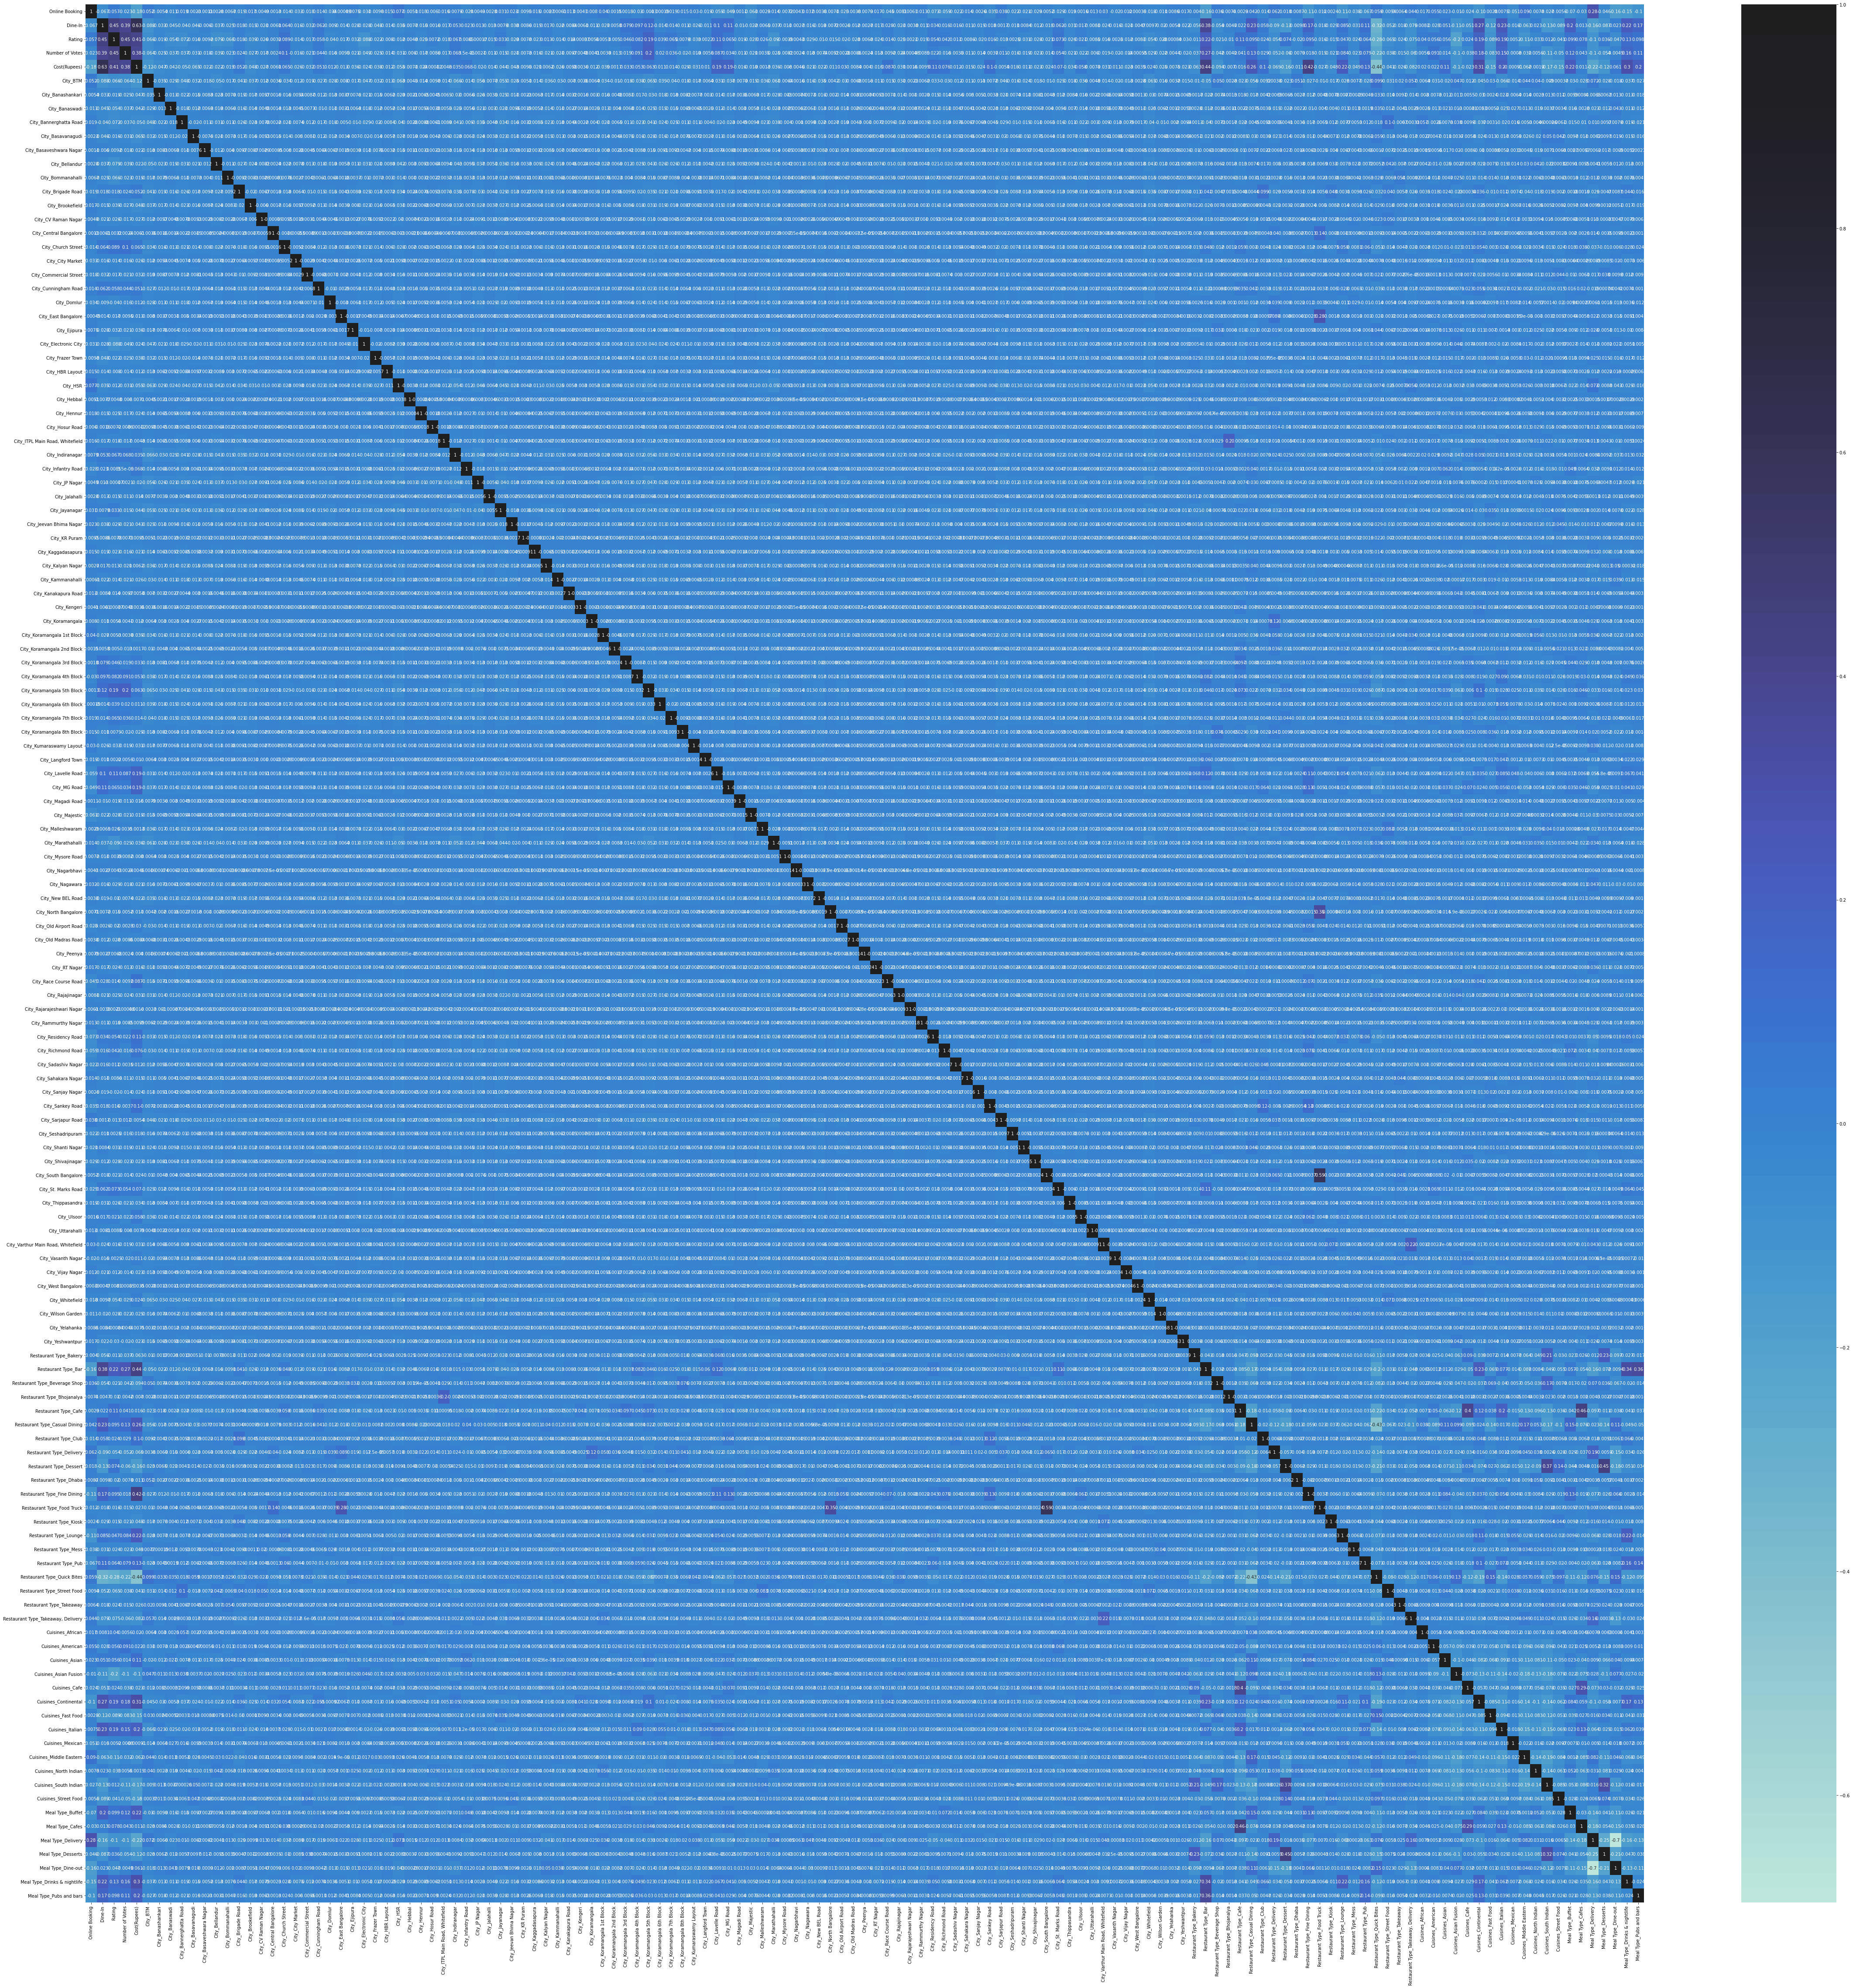

In [57]:
plt.figure(figsize = (80, 80))
corr=data_norm.corr()
sns.heatmap(corr, annot = True, center=1)
plt.show()

<Figure size 1152x720 with 0 Axes>

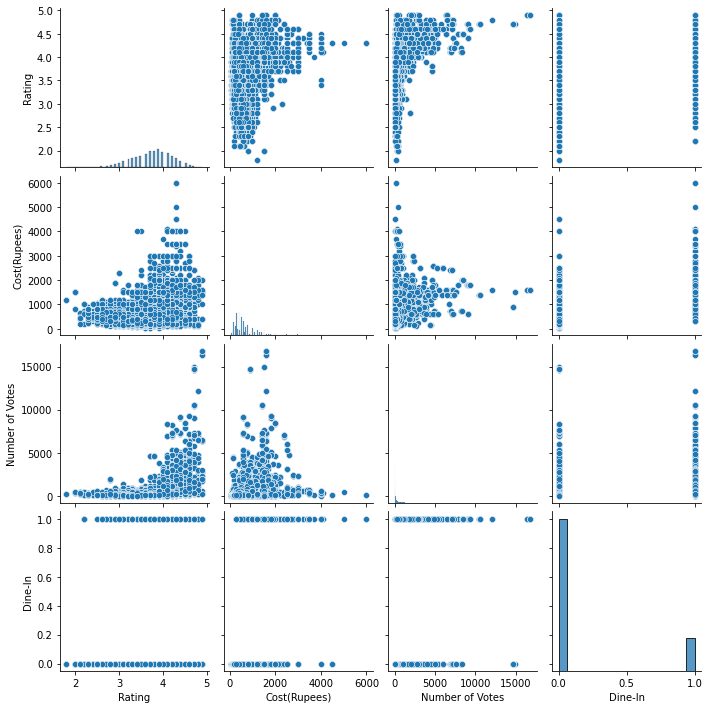

In [58]:
plt.figure(figsize=(16,10))
sns.pairplot(data_norm,  vars=['Rating','Cost(Rupees)', 'Number of Votes', 'Dine-In'])
plt.show()

<AxesSubplot:>

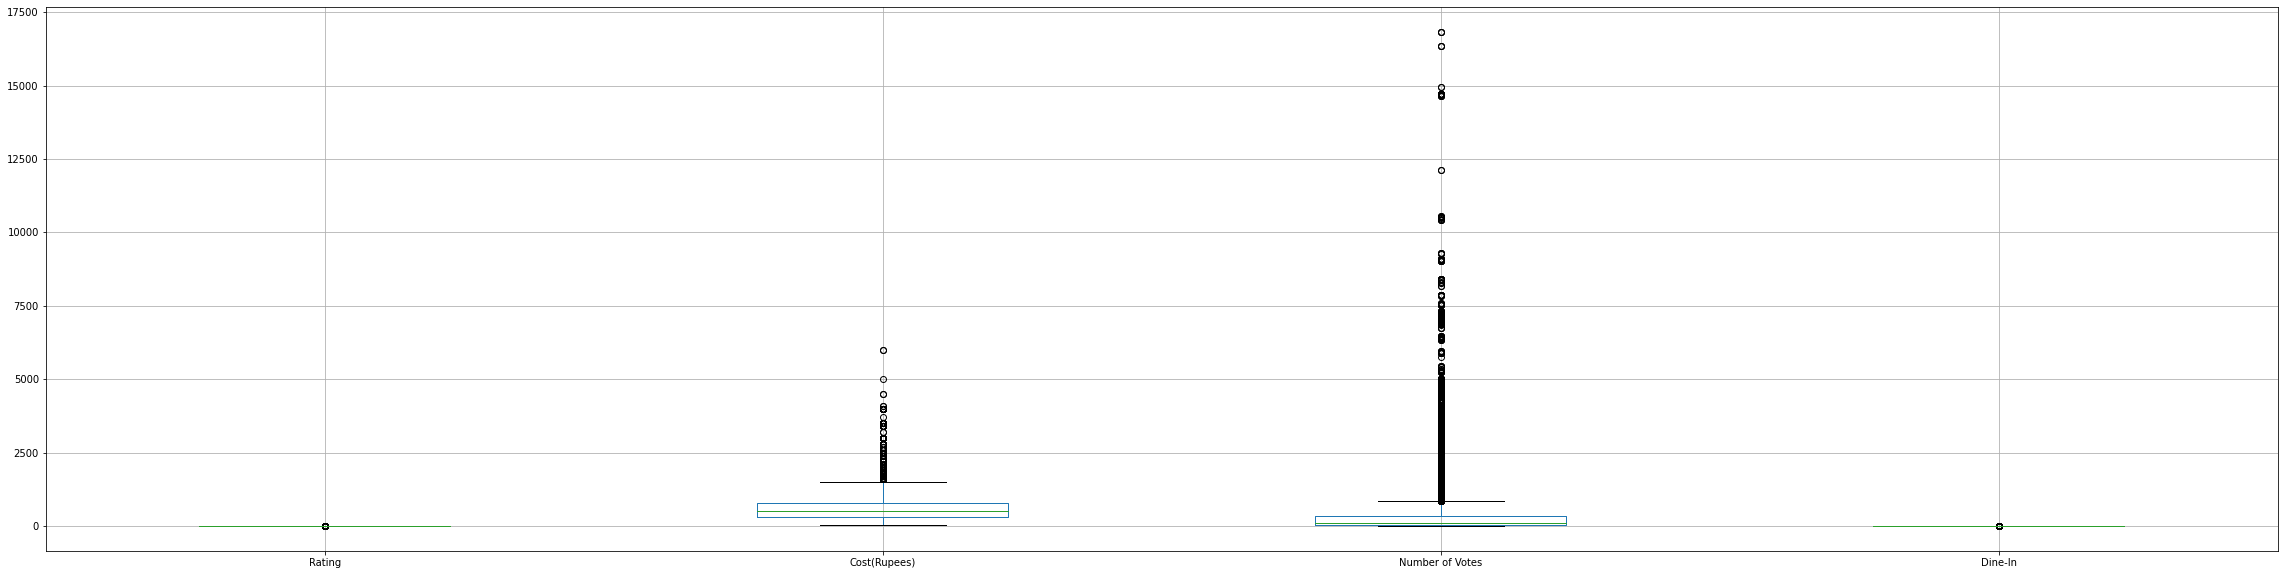

In [59]:
plt.figure(figsize=(40,10))
data_norm.boxplot(column=['Rating','Cost(Rupees)', 'Number of Votes', 'Dine-In'])

1.Number of Votes
2.Cost of Rupees
3.Dine-In

**In the multivariate models are predictor variables independent of all the other predictor variables?**<br>
**Is there any multicollinearity in the model?**

In [60]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = data_norm.columns
vif["vif_Factor"] = [variance_inflation_factor(data_norm.values, i) for i in range(data_norm.shape[1])]
vif

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


features  vif_Factor
0                  Online Booking    1.219583
1                         Dine-In    2.031350
2                          Rating    1.689793
3                 Number of Votes    1.468768
4                    Cost(Rupees)    4.260843
..                            ...         ...
132            Meal Type_Delivery         inf
133            Meal Type_Desserts         inf
134            Meal Type_Dine-out         inf
135  Meal Type_Drinks & nightlife         inf
136       Meal Type_Pubs and bars         inf

[137 rows x 2 columns]

It is usually considered to be highly correlated if the VIF value is higher than 5. None of the values we were looking at show a VIF value of 5 so we can assume there is no multicollinearly.<br>
A large vif in the constant indicates that the (slope) explanatory variables have also a large constant component. An example would be when a variable has a large mean but only a small variance.

**Is the relationship significant?**

In [61]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(data_norm['Rating'], data_norm[['Number of Votes', 'Cost(Rupees)', 'Dine-In']], axis =1).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Rating   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                          2.206e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):                        0.00
Time:                        02:24:41   Log-Likelihood:                         -63919.
No. Observations:               29638   AIC:                                  1.278e+05
Df Residuals:                   29635   BIC:                                  1.279e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Number of Votes     0.0002   1.33e-05     11.768      0.000       0.000       0.000
Cost(Rupees)        0.0043   2.18e-05    199.419      0.000       0.004       0.004
Dine-In            -1.6047      0.040    -39.943      0.000      -1.683      -1.526
==============================================================================
Omnibus:                    16556.574   Durbin-Watson:                   0.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           182474.315
Skew:                          -2.494   Prob(JB):                         0.00
Kurtosis:                      14.086   Cond. No.                     3.98e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

According to the low p-value and high t-statistic for a majority of the data, we can say that the relationship between the number of votes and cost is significant in addition to other categorical variables. We will further drill down which fields are exactly useful in predicing ratings in a cleaner way with AutoML

##Building the model
###Initializing H2O
###Modeling (AutoML)
The aim of this node is to create predictive models in AutoML, find the best model to predict restaurant ratings, and interpret each model. We will explore:

Answer the following questions for all of the models:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

In [62]:
min_mem_size=6 
run_time=333

In [63]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [64]:
#installing dependencies
!pip install eli5
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjlnpdn0g
  JVM stdout: /tmp/tmpjlnpdn0g/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjlnpdn0g/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.1
H2O_cluster_version_age:    17 days
H2O_cluster_name:           H2O_from_python_unknownUser_862hjb
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  ----------------------------------

In [66]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [67]:
#Viewing data 
data = h2o.H2OFrame(data_clean)
data.shape
data.describe()
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:29638
Cols:9

Online Booking      Dine-In              Rating              Number of Votes     City          Restaurant Type    Cuisines        Cost(Rupees)       Meal Type
-------  ------------------  -------------------  ------------------  ------------------  ------------  -----------------  --------------  -----------------  -----------
type     int                 int                  real                int                 enum          enum               enum            int                enum
mins     0.0                 0.0                  1.8                 0.0                                                                  40.0
mean     0.648019434509751   0.17929684864025913  3.7328497199541175  425.3797827113847                                                    634.0447398609892
maxs     1.0                 1.0                  4.9                 16832.0                                                              6000.0
sigma    0.4775960041068574  0.3836071607362359   0.4521880727433133  1007.2929150656364                                                   480.9124985000013
zeros    10432               24324                0                   19                                                                   0
missing  0                   0                    0                   0                   0             0                  0               0                  0
0        1.0                 1.0                  4.1                 775.0               Banashankari  Casual Dining      Middle Eastern  800.0              Buffet
1        1.0                 0.0                  4.1                 787.0               Banashankari  Casual Dining      Asian Fusion    800.0              Buffet
2        1.0                 0.0                  3.8                 918.0               Banashankari  Casual Dining      Italian         800.0              Buffet
3        0.0                 0.0                  3.7                 88.0                Banashankari  Quick Bites        North Indian    300.0              Buffet
4        0.0                 0.0                  3.8                 166.0               Basavanagudi  Casual Dining      North Indian    600.0              Buffet
5        1.0                 0.0                  3.8                 286.0               Basavanagudi  Casual Dining      North Indian    600.0              Buffet
6        0.0                 0.0                  3.6                 8.0                 Mysore Road   Casual Dining      Asian Fusion    800.0              Buffet
7        1.0                 1.0                  4.6                 2556.0              Banashankari  Casual Dining      Italian         600.0              Cafes
8        1.0                 0.0                  4.0                 324.0               Banashankari  Cafe               Italian         700.0              Cafes
9        1.0                 0.0                  4.2                 504.0               Banashankari  Cafe               Italian         550.0              Cafes
[29638 rows x 9 columns]

Online Booking    Dine-In    Rating    Number of Votes  City          Restaurant Type    Cuisines          Cost(Rupees)  Meal Type
----------------  ---------  --------  -----------------  ------------  -----------------  --------------  --------------  -----------
               1          1       4.1                775  Banashankari  Casual Dining      Middle Eastern             800  Buffet
               1          0       4.1                787  Banashankari  Casual Dining      Asian Fusion               800  Buffet
               1          0       3.8                918  Banashankari  Casual Dining      Italian                    800  Buffet
               0          0       3.7                 88  Banashankari  Quick Bites        North Indian               300  Buffet
               0          0       3.8                166  Basavanagudi  Casual Dining      North Indian               600  Buffet
               1          0       3.8                286  Basavanagudi  Casual Dining      North Indian               600  Buffet
               0          0       3.6                  8  Mysore Road   Casual Dining      Asian Fusion               800  Buffet
               1          1       4.6               2556  Banashankari  Casual Dining      Italian                    600  Cafes
               1          0       4                  324  Banashankari  Cafe               Italian                    700  Cafes
               1          0       4.2                504  Banashankari  Cafe               Italian                    550  Cafes
[10 rows x 9 columns]

##predicting rating
Now that we have initialized H2O with the zomato dataset, we should split the values into training and test datasets for verification.

In [68]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [69]:
# assign target and inputs for logistic regression
y = 'Rating'
X = [name for name in train.columns if name != y]
print(y)
print(X)

Rating
['Online Booking', 'Dine-In', 'Number of Votes', 'City', 'Restaurant Type', 'Cuisines', 'Cost(Rupees)', 'Meal Type']


In [70]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

Using AutoML, pass in training and testing datasets as well as the predictor values to predict Rating.

In [71]:
aml.train(x=X,y=y,training_frame=train)  # Change training_frame=train

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_1_20230226_22544


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  2/11
# GBM base models (used / total)      1/5
# XGBoost base models (used / total)  0/3
# DRF base models (used / total)      1/2
# GLM base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.010782111880242147
RMSE: 0.1038369485310607
MAE: 0.06559399619499494
RMSLE: 0.023938493900240353
Mean Residual Deviance: 0.010782111880242147
R^2: 0.9468423150830059
Null degrees of freedom: 9957
Residual degrees of freedom: 9955
Null deviance: 2019.876472569916
Residual deviance: 107.3682701034513
AIC: -16840.834020332884

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.03893337909913157
RMSE: 0.19731543046384276
MAE: 0.12238698044482596
RMSLE: 0.044992898993997964
Mean Residual Deviance: 0.03893337909913157
R^2: 0.8090498792758425
Null degrees of freedom: 22310
Residual degrees of freedom: 22308
Null deviance: 4549.399884099035
Residual deviance: 868.6426210807244
AIC: -9095.473783249334

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.122374   0.00205113  0.120203      0.120186      0.124528      0.123839      0.123111
mean_residual_deviance  0.0389204  0.00183156  0.036765      0.0373262     0.0409906     0.0402774     0.0392426
mse                     0.0389204  0.00183156  0.036765      0.0373262     0.0409906     0.0402774     0.0392426
null_deviance           909.88     31.4999     858.939       911.808       933.096       906.991       938.566
r2                      0.809065   0.00722934  0.81201       0.817276      0.801012      0.801887      0.813139
residual_deviance       173.729    9.7727      161.435       166.587       185.647       179.677       175.297
rmse                    0.197239   0.0046494   0.191742      0.1932        0.202461      0.200692      0.198097
rmsle                   0.0449725  0.00118335  0.0436528     0.0438501     0.0462455     0.0459418     0.0451722

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [72]:
print(aml.get_leaderboard().head(20))

model_id                                                    rmse        mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20230226_22544     0.197315  0.0389334  0.122387  0.0449929                 0.0389334
StackedEnsemble_BestOfFamily_3_AutoML_1_20230226_22544  0.19732   0.0389351  0.122393  0.0449938                 0.0389351
StackedEnsemble_AllModels_3_AutoML_1_20230226_22544     0.197327  0.038938   0.122402  0.0449955                 0.038938
StackedEnsemble_BestOfFamily_2_AutoML_1_20230226_22544  0.197329  0.0389388  0.1224    0.0449966                 0.0389388
StackedEnsemble_AllModels_1_AutoML_1_20230226_22544     0.197329  0.0389389  0.122397  0.0449962                 0.0389389
GBM_4_AutoML_1_20230226_22544                           0.198439  0.039378   0.122075  0.045305                  0.039378
DRF_1_AutoML_1_20230226_22544                           0.204117  0.0416637  0.130795  0.0467634                 0.0416637
GBM_3_AutoML_1_202

##Answers of the each model

###Default Random Forest

In [87]:
drfmodel = h2o.get_model(aml.leaderboard[6,'model_id'])
drfmodel.algo

'drf'

In [88]:
perf = drfmodel.model_performance(test)
perf

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.03572929784453881
RMSE: 0.18902195069498887
MAE: 0.11824035402562201
RMSLE: 0.043311210199962515
Mean Residual Deviance: 0.03572929784453881

**Are any model assumptions violated?**

No formal distributional assumptions, random forests are non-parametric and can thus handle skewed and multi-modal data as well as categorical data that are ordinal or non-ordinal

**Which independent variables are significant?**

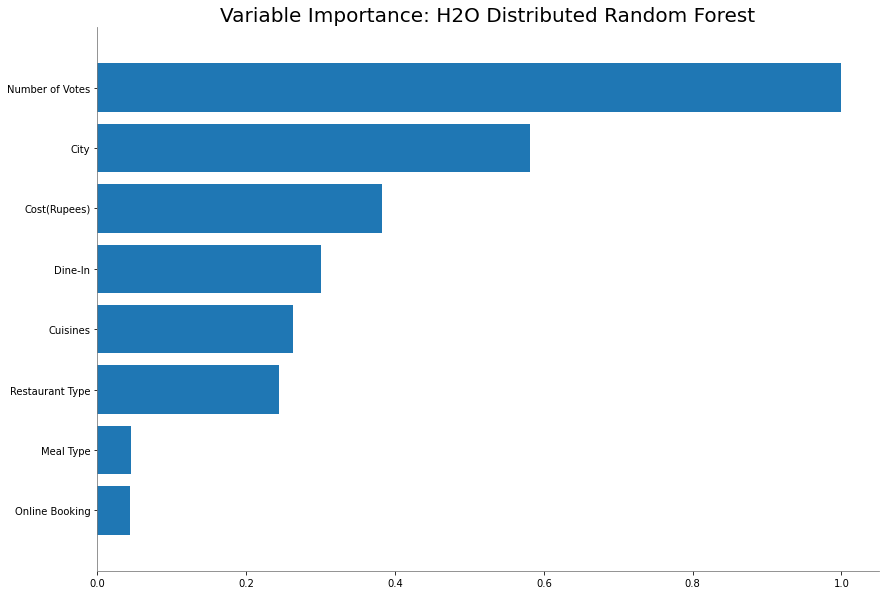

<Figure size 432x288 with 0 Axes>

In [100]:
drfmodel.varimp_plot()

Based off of the variance importance plot, we see that in the DRF model, Number of Votes and City are the most significant independent variables

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

1.Number of Votes<br>
2.City

**Which hyperparameters are important?**

1.ntrees which is the number of trees to split by<br>
2.learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [103]:
drfmodel

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20230226_22544


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    36                 36                          3.20382e+06            20           20           20            4703          6235          5712.39

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.037739043840114804
RMSE: 0.19426539537476767
MAE: 0.12309589967876983
RMSLE: 0.0446094732349702
Mean Residual Deviance: 0.037739043840114804

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.04166365477277218
RMSE: 0.20411676749540245
MAE: 0.13079495124403318
RMSLE: 0.04676342351430532
Mean Residual Deviance: 0.04166365477277218

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.130795   0.0025072   0.131388      0.133035      0.130411      0.132453      0.126687
mean_residual_deviance  0.0416637  0.00181526  0.0413644     0.0445305     0.0395607     0.0418449     0.0410179
mse                     0.0416637  0.00181526  0.0413644     0.0445305     0.0395607     0.0418449     0.0410179
r2                      0.795665   0.00800393  0.794791      0.782291      0.802853      0.799284      0.799108
residual_deviance       0.0416637  0.00181526  0.0413644     0.0445305     0.0395607     0.0418449     0.0410179
rmse                    0.204078   0.00442064  0.203382      0.211023      0.198899      0.20456       0.202529
rmsle                   0.0467535  0.0010785   0.0466664     0.0482177     0.0452127     0.0470737     0.0465968

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-02-26 02:29:09  19.881 sec  0                  nan              nan             nan
    2023-02-26 02:29:10  20.389 sec  5                  0.252149         0.145367        0.0635791
    2023-02-26 02:29:10  20.761 sec  10                 0.224126         0.135874        0.0502324
    2023-02-26 02:29:11  21.114 sec  15                 0.20949          0.130679        0.0438862
    2023-02-26 02:29:11  21.509 sec  20                 0.202912         0.127963        0.0411735
    2023-02-26 02:29:11  21.904 sec  25                 0.19817          0.124978        0.0392712
    2023-02-26 02:29:12  22.280 sec  30                 0.196462         0.124002        0.0385973
    2023-02-26 02:29:12  22.659 sec  35                 0.19415          0.122766        0.0376944
    2023-02-26 02:29:12  22.734 sec  36                 0.194265         0.123096        0.037739

Variable Importances: 
variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  ------------
Number of Votes  37585.2                1                    0.349543
City             21858.8                0.581581             0.203288
Cost(Rupees)     14388                  0.382811             0.133809
Dine-In          11310.7                0.300936             0.10519
Cuisines         9875.44                0.262748             0.091842
Restaurant Type  9156.27                0.243614             0.0851536
Meal Type        1698.57                0.0451925            0.0157967
Online Booking   1653.42                0.0439914            0.0153769

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.displ

###Gradient Boosting Machine

In [90]:
gbmmodel = h2o.get_model(aml.leaderboard[5,'model_id'])
gbmmodel.algo

'gbm'

In [91]:
perf = gbmmodel.model_performance(test)
perf

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.03479683848748546
RMSE: 0.18653910712632207
MAE: 0.11342515992983312
RMSLE: 0.04259147241563152
Mean Residual Deviance: 0.03479683848748546

**Are any model assumptions violated?**

Assumes that encoded integer value for each variable has ordinal relation.

In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

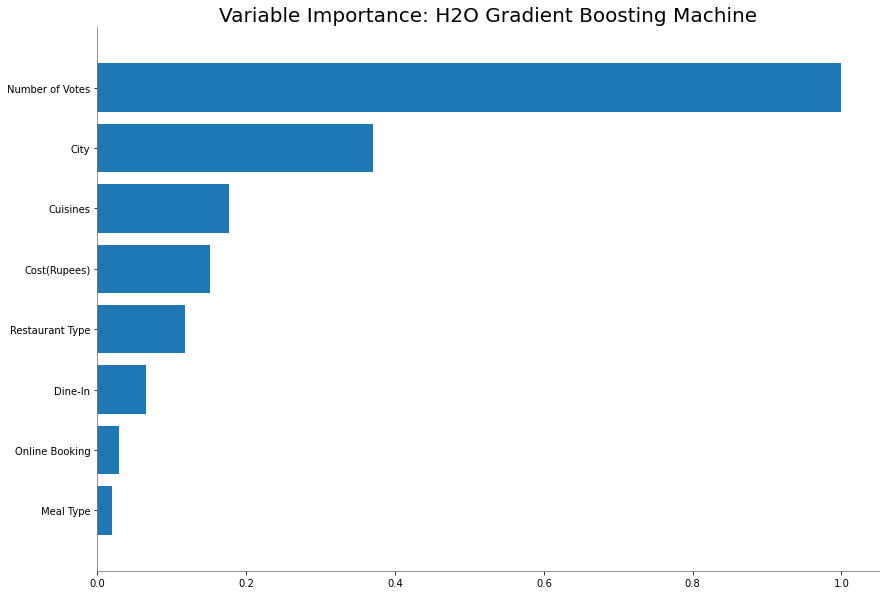

<Figure size 432x288 with 0 Axes>

In [98]:
gbmmodel.varimp_plot()


Based off of the variance importance plot, we see that in the GBM model, Number of Votes and City are the most significant independent variables

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

Number of Votes,
City


**Which hyperparameters are important?**

ntrees which is the number of trees to split by<br>
learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [101]:
gbmmodel

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20230226_22544


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    174                174                         992677                 10           10           9.48276       1             574           352.983

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.011016659754703761
RMSE: 0.10496027703233143
MAE: 0.06478122059583269
RMSLE: 0.024276983780514284
Mean Residual Deviance: 0.011016659754703761

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.03937795677340678
RMSE: 0.1984387985586659
MAE: 0.1220749531470784
RMSLE: 0.04530495637650453
Mean Residual Deviance: 0.03937795677340678

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.122075   0.00404536  0.12117       0.126109      0.122841      0.12461       0.115645
mean_residual_deviance  0.039378   0.00211948  0.0378345     0.0429565     0.037943      0.0395984     0.0385577
mse                     0.039378   0.00211948  0.0378345     0.0429565     0.037943      0.0395984     0.0385577
r2                      0.806884   0.00948015  0.812303      0.789986      0.810915      0.810059      0.811157
residual_deviance       0.039378   0.00211948  0.0378345     0.0429565     0.037943      0.0395984     0.0385577
rmse                    0.198383   0.00527157  0.194511      0.20726       0.19479       0.198993      0.196361
rmsle                   0.0452908  0.00126704  0.0445754     0.0473104     0.0440425     0.0456312     0.0448947

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  --------------------
     2023-02-26 02:30:26  21.863 sec  0.0                0.45154504469153406  0.36309238160994106  0.2038929273854795
     2023-02-26 02:30:26  21.980 sec  5.0                0.34006455742142677  0.2631008667561374   0.11564390321423085
     2023-02-26 02:30:26  22.100 sec  10.0               0.2781195231267097   0.20836077765098504  0.07735046914422838
     2023-02-26 02:30:27  22.214 sec  15.0               0.24504692457955773  0.17715773439905322  0.06004799524589945
     2023-02-26 02:30:27  22.323 sec  20.0               0.22325827514348567  0.15640562428389834  0.049844257420044356
     2023-02-26 02:30:27  22.435 sec  25.0               0.20718137827758162  0.14212942635279427  0.04292412350499837
     2023-02-26 02:30:27  22.551 sec  30.0               0.19263781584157702  0.1301122451425908   0.037109328092213345
     2023-02-26 02:30:27  22.671 sec  35.0               0.1823510011369731   0.12176598536963422  0.033251887615656374
     2023-02-26 02:30:27  22.779 sec  40.0               0.17547251328256375  0.11645712448969195  0.030790602917699507
     2023-02-26 02:30:27  22.897 sec  45.0               0.1673984522378238   0.1102477279228117   0.028022241811618973
---  ---                  ---         ---                ---                  ---                  ---
     2023-02-26 02:30:29  24.801 sec  130.0              0.11593402373787237  0.07263627833891767  0.013440697860053554
     2023-02-26 02:30:29  24.914 sec  135.0              0.11434298442854075  0.07149973952632917  0.013074318088025512
     2023-02-26 02:30:29  25.025 sec  140.0              0.11230452957062351  0.07002508327719568  0.01261230736207905
    

**Does regularization help?**

GBM does not have regularization so it is prone to overfitting. To correct this issue, we use XGBoosting that incorporates the regularization formalization in the loss function. As we will see later, regularization does not help the model's performance.

**Does the model make sense?**

Gradient Boosting Machine is an Ensemble Learning method using Boosting to predict models. Per the output, we can understand that Number of Votes and the location (City) can help predict ratings for resturants. This makes sense since places with a lot of people will have a lot of things to say about places and people tend to trust the majority, especially when it comes to food.

###XGBoost

In [94]:
xgbmodel = h2o.get_model(aml.leaderboard[9,'model_id'])
xgbmodel.algo

'xgboost'

In [95]:
perf = xgbmodel.model_performance(test)
perf

ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 0.04450031558474989
RMSE: 0.2109509791035583
MAE: 0.14019347720994166
RMSLE: 0.04771912295029171
Mean Residual Deviance: 0.04450031558474989

**Are any model assumptions violated?**

The main assumptions of XGBoost are:

XGBoost may assume that encoded integer values for each input variable have an ordinal relationship<br>
XGBoost assume that your data may not be complete (i.e. it can deal with missing values)<br>


In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

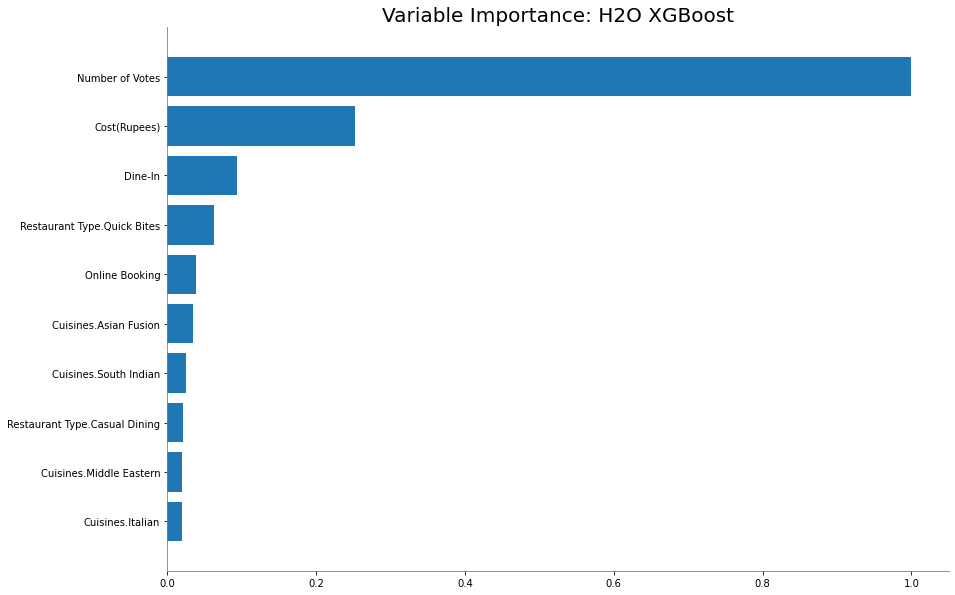

<Figure size 432x288 with 0 Axes>

In [99]:
xgbmodel.varimp_plot()

Based off the variance importance plot, we see that Number of Votes and Cost are the most significant independent variables in a XGBoost model.


**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

Number of Votes,
Cost (Rupees)


**Which hyperparameters are important?**

ntrees which is the number of trees to split by<br>
learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [102]:
xgbmodel

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20230226_22544


Model Summary: 
    number_of_trees
--  -----------------
    124

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.015051527647556852
RMSE: 0.12268466753248693
MAE: 0.08547315272247928
RMSLE: 0.02795687647653789
Mean Residual Deviance: 0.015051527647556852

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.051318289138718665
RMSE: 0.22653540372029857
MAE: 0.15272876593443724
RMSLE: 0.05132044260526919
Mean Residual Deviance: 0.051318289138718665

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.152729   0.00624265  0.15304       0.155943      0.153432      0.158861      0.142367
mean_residual_deviance  0.0513183  0.00311765  0.0505894     0.0546993     0.0488985     0.0544452     0.0479592
mse                     0.0513183  0.00311765  0.0505894     0.0546993     0.0488985     0.0544452     0.0479592
r2                      0.748375   0.0130778   0.749026      0.732576      0.756319      0.738844      0.765112
residual_deviance       0.0513183  0.00311765  0.0505894     0.0546993     0.0488985     0.0544452     0.0479592
rmse                    0.226452   0.00687012  0.224921      0.233879      0.22113       0.233335      0.218996
rmsle                   0.0513009  0.00158272  0.0511        0.0527706     0.0498657     0.0530792     0.0496892

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  --------------------
     2023-02-26 02:27:07  1 min 22.961 sec  0.0                3.263472432798734    3.2320828257102465   10.650252319637286
     2023-02-26 02:27:07  1 min 23.142 sec  5.0                0.6282559046818136   0.5776268389495258   0.394705481767564
     2023-02-26 02:27:08  1 min 23.367 sec  10.0               0.2747360025869617   0.21601004055745235  0.07547987111746302
     2023-02-26 02:27:08  1 min 23.521 sec  15.0               0.24033959188523396  0.1729466727802495   0.057763119427560815
     2023-02-26 02:27:08  1 min 23.668 sec  20.0               0.22625155743996828  0.15993428651319755  0.05118976724401126
     2023-02-26 02:27:08  1 min 23.806 sec  25.0               0.21784376003416922  0.1535395499405496   0.047455903785824705
     2023-02-26 02:27:08  1 min 23.977 sec  30.0               0.20628898559148973  0.1455204600440644   0.04255514557636585
     2023-02-26 02:27:08  1 min 24.150 sec  35.0               0.19963602080490847  0.1406204582494931   0.03985454080281785
     2023-02-26 02:27:09  1 min 24.340 sec  40.0               0.18952491751330863  0.132843688860376    0.03591969435842644
     2023-02-26 02:27:09  1 min 24.518 sec  45.0               0.18349450630645678  0.1284523838964444   0.03367023384465031
---  ---                  ---               ---                ---                  ---                  ---
     2023-02-26 02:27:10  1 min 26.110 sec  80.0               0.1518090853685372   0.10586152580679785  0.023045998400431818
     2023-02-26 02:27:11  1 min 26.376 sec  85.0               0.14736268143571654  0.10274687688977206  0.021715759879924478
     2023-02-26 02:27:11  1 min 26.643 sec  90.0               0.14300792408430033  0.09958635066423395  0.02045126635090101
     2023-02-26 02:27:11  1 min 26.919 sec  95.0               0.1383186972513351   0.09645680127527065  0.019132062009306502
     2023-02-26 02:27:12  1 min 27.224 sec  100.0              0.13518205893838128  0.0942331909476164   0.01827418905881999
     2023-02-26 02:27:12  1 min 27.517 sec  105.0              0.13201406510770672  

**Does regularization help?**

XGBoost comes built in with regularization. By comparing XGBoost and GBM, we see that the logloss score for GBM is much lower and therefore a better model for this dataset.

**Does the model make sense?**

Viewing the variance importance plot, we instead see that the Number of Votes and Cost play a big role in predicting ratings by model. This would also make sense because with 5 star restaurants that are really expensive, we would expect high quality food whereas with 1 star restaurants, you would expect the food to be less expensive.

By using AutoML, we found three models that perform the best on the Zomato dataset. As predicted, we did not see any linear models observed in from AutoML. As per our experiment, we saw a variation of decision trees and boosting algorithms. The best model for our data set has been the Gradient Boosting Machine with a logloss score of 0.28. Some errors in the model can be account by the fact that our dataset violated an assumption of the GBM model because the categorical variables do not have an ordinal relationship.

##Linear Model

**Are any model assumptions violated?**

General Linear Modeling makes four assumptions: linearity, homoskedasticity (constant variance), normality, and independence.

<Figure size 576x360 with 0 Axes>

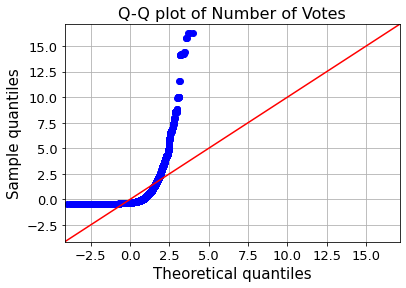

<Figure size 576x360 with 0 Axes>

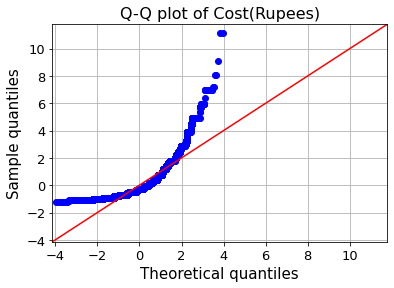

In [96]:
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
data_temp=data_clean[['Number of Votes', 'Cost(Rupees)']]
for c in data_temp.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_temp[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

Looking at the Q-Q plot above, it appears that both numeric independent variables are not normally distributed but instead follow a exponential distribution<br>
The predictors looks right skewed with a few outliers for entries for the higher values

In [97]:
print("Skewness of Votes: %f" % data_clean['Number of Votes'].skew())
print("Kurtosis of Votes: %f" % data_clean['Number of Votes'].kurt())
print("Skewness of Cost: %f" % data_clean['Cost(Rupees)'].skew())
print("Kurtosis of Cost: %f" % data_clean['Cost(Rupees)'].kurt())

Skewness of Votes: 6.156129
Kurtosis of Votes: 57.959362
Skewness of Cost: 2.259205
Kurtosis of Cost: 7.984325


Double checking we see an indeed right skewness of both variables. The high kurtosis tells us that the data has heavier tails (or outliers).<br>

Additionally, based off the pairplots, we see datasets have heteroskedasticity as the variance for Number of Votes and Cost is not constant over time.<br>

The dataset does display variable independence as all VIF scores are below 5.<br>

Therefore, linearity, normality, and homoskedasticity are violated.<br>

##Conclusion


From the analysis done above on the data set, it is clear that there is multicolinearity and except length all other dependent variables are significant

References:<br>
Sckit learn offcial documentation<br>
Refered Towards Data Science<br>
Eli5 official documentation<br>
https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea<br>
https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook<br>
The algorithms were referred directly from the Sckit learn official documentation. Visualization was referred from the Machine Learning with scikit-learn Quick Start Guide and Towards Data Science (How do you check the quality of your regression model in Python?). The remaining code was written independently. Feature importance reference is taken from eli5 offical documnetation

Copyright (C) <2022> Divya Myneni

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE